# Setting

In [0]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"young917","key":"38554d8ee11a16273014fb43b7fdc0a1"}'}

In [0]:
%ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                               deadline             category            reward  teamCount  userHasEntered  
------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                                  2030-01-01 00:00:00  Getting Started  Knowledge       3183           False  
titanic                                           2030-01-01 00:00:00  Getting Started  Knowledge      23884           False  
house-prices-advanced-regression-techniques       2030-01-01 00:00:00  Getting Started  Knowledge       5405            True  
connectx                                          2030-01-01 00:00:00  Getting Started  Knowledge        374           False  
nlp-getting-started                               2030-01-01 00:00:00  Getting Started      Kudos       1696            True  
competitive-data-science-predict-future-sales     2020-12-31 23:59:00  Playground           Kudos       7308   

In [0]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 65.8MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 23.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 132MB/s]


# **Data Load**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 200)
import spacy

plt.rcParams["figure.figsize"] = (15,5)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [0]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3


#### Data Cleaning

In [0]:
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub

In [0]:
import nltk

nltk.download('stopwords')
stop=set(stopwords.words('english'))

punctuation = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##### train과 test set에서 URL, html, 구두점을 삭제한다.

In [0]:
df=pd.concat([train,test])
df.shape

(10876, 5)

In [0]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn,NaN
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power,NaN
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/UtbXLcBIuY,NaN
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3,NaN


In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

In [0]:
import re

# remove http
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

# remove HTML tags
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x : remove_emoji(x))

# https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
slang_abbrev_dict = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'B4N': 'Bye For Now',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': 'For What It\'s Worth',
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you',
    'ILU': 'I Love You',
    'IMHO': 'In My Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My Ass Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'OMG': 'Oh My God',
    'PITA': 'Pain In The Ass',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My Ass Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The Fuck',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait',
    '7K': 'Sick:-D Laugher'
}
def unslang(text):
    if text.upper() in slang_abbrev_dict.keys():
        return slang_abbrev_dict[text.upper()]
    else:
        return text
df['text']=df['text'].apply(lambda x : unslang(x))

# remove punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text']=df['text'].apply(lambda x : remove_punct(x))

def tokenization(text):
    text = re.split('\W+', text)
    return text
df['text']=df['text'].apply(lambda x : tokenization(x.lower()))

In [0]:
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
df['text']=df['text'].apply(lambda x : remove_stopwords(x))

'''
def stemming(text):
    text = [stemmer.stem(word) for word in text]
    return text
df['text']=df['text'].apply(lambda x : stemming(x))
'''

df['text']=df['text'].apply(lambda x : ' '.join(x))

In [0]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,forest fire near la ronge sask canada,1.0
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1.0
3,6,NaN,NaN,13000 people receive wildfires evacuation orders california,1.0
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1.0
...,...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety fasteners xrwn,NaN
3259,10865,NaN,NaN,storm ri worse last hurricane cityamp3others hardest hit yard looks like bombed around 20000k still without power,NaN
3260,10868,NaN,NaN,green line derailment chicago,NaN
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo,NaN


## **Model**

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 4.5MB/s 


#### Encoding

In [0]:
# text -> tokens with padding
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 30.1 s, sys: 5.5 s, total: 35.6 s
Wall time: 43.1 s


In [0]:
import tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [0]:
train = df[:-3263]
test = df[-3263:]

In [0]:
# Remove the mislabelled tweets
incorrect_labels_df = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
incorrect_labels_df = incorrect_labels_df[incorrect_labels_df['target'] > 1]
incorrect_texts = incorrect_labels_df.index.tolist()
train = train[~train.text.isin(incorrect_texts)]

In [0]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

#### Build Model

In [0]:
INIT_LR = 2e-7
EPOCHS = 30

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    drop_out = tf.keras.layers.Dropout(0.4)(clf_output)
    out = Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop_out)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=INIT_LR, decay=INIT_LR / (EPOCHS)), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

In [0]:
%%time
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=8,
    callbacks=[es, mc]
)

Epoch 1/30
736/736 [==============================] - 455s 618ms/step - loss: 0.6540 - accuracy: 0.6418 - val_loss: 0.5616 - val_accuracy: 0.7480
Epoch 2/30
736/736 [==============================] - 454s 616ms/step - loss: 0.5582 - accuracy: 0.7351 - val_loss: 0.5027 - val_accuracy: 0.7853
Epoch 3/30
736/736 [==============================] - 459s 624ms/step - loss: 0.5099 - accuracy: 0.7771 - val_loss: 0.4727 - val_accuracy: 0.7962
Epoch 4/30
736/736 [==============================] - 455s 619ms/step - loss: 0.4749 - accuracy: 0.7973 - val_loss: 0.4581 - val_accuracy: 0.8057
Epoch 5/30
736/736 [==============================] - 449s 610ms/step - loss: 0.4541 - accuracy: 0.8093 - val_loss: 0.4420 - val_accuracy: 0.8091
Epoch 6/30
736/736 [==============================] - 455s 618ms/step - loss: 0.4278 - accuracy: 0.8201 - val_loss: 0.4338 - val_accuracy: 0.8125
Epoch 7/30
736/736 [==============================] - 455s 619ms/step - loss: 0.4076 - accuracy: 0.8292 - val_loss: 0.4355 -

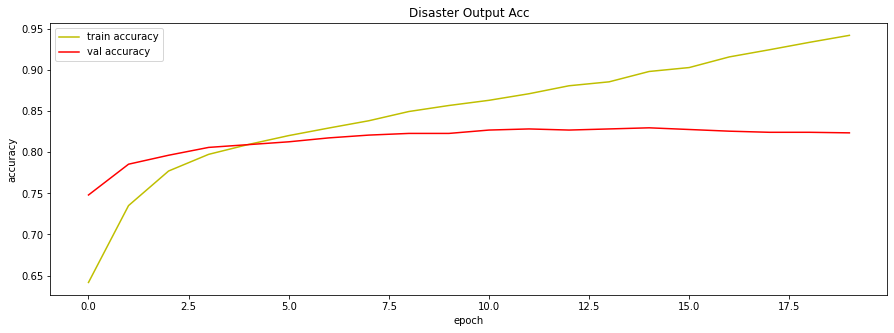

In [0]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.plot(train_history.history['accuracy'], 'y', label='train accuracy')
plt.plot(train_history.history['val_accuracy'], 'r', label='val accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Disaster Output Acc")

plt.show()

In [0]:
# model.save('Bertmodel.h5')

In [0]:
# cp './Bertmodel.h5' '/content/gdrive/My Drive/Data Mining Project/Bertmodel.h5'

## Submission

In [0]:
# load a saved model
model = tf.keras.models.load_model('best_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [0]:
submission=pd.read_csv('./sample_submission.csv')

In [0]:
test_pred = model.predict(test_input)
submission['target'] = test_pred.round().astype(int)
submission.to_csv('submission.csv', index=False)

In [0]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [0]:
# !kaggle competitions submit -c nlp-getting-started -f submission.csv -m "BERT"

In [0]:
!cp './submission.csv' '/content/drive/My Drive/Data Mining Project/BERT_v2.csv'

cp: cannot stat './submission.csv': No such file or directory


In [0]:
# submission